# Метрики качества классификации

## 1. Данные

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Users\econo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
X = pd.read_pickle('data/shelter/xtrain.pkl')
y = pd.read_csv('data/shelter/train.csv')['OutcomeType']

для учебных примеров оставим только 2 класса, отличающихся значительно и по смыслу, и по размеру

In [4]:
y.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [5]:
is_first_2_class = (y=='Adoption')|(y=='Euthanasia')

In [6]:
X = X[is_first_2_class]
X.index = range(len(X))
y = y[is_first_2_class]
y.index = range(len(y))

y теперь можно перевести в множество {0,1}

In [7]:
y = (y=='Adoption').astype(int)

для оценки качества разобьём выборки на 2 части, 3:1

In [8]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.25)

-----

## 2. Обучим классификатор

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
clf = DecisionTreeClassifier(max_depth=5)

In [11]:
clf.fit(Xtr, ytr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [12]:
yval_pred = clf.predict(Xval)
yval_pred_proba = clf.predict_proba(Xval)

-----

## 3. Написание метрик с нуля

In [13]:
from sklearn import metrics

-----

In [14]:
metrics.confusion_matrix(yval, yval_pred)

array([[ 213,  136],
       [  17, 2715]], dtype=int64)

In [15]:
metrics.accuracy_score(yval, yval_pred)

0.9503407984420643

In [16]:
metrics.precision_score(yval, yval_pred)

0.9522974394949141

In [17]:
metrics.recall_score(yval, yval_pred)

0.9937774524158126

In [18]:
metrics.roc_auc_score(yval, yval_pred_proba[:,1])

0.9285995964206454

In [19]:
metrics.average_precision_score(yval, yval_pred_proba[:,1])

0.9848933712563651

## Реализовать самостоятельно вывод графика ROC-AUC

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
def calculate_tpr_and_fpr(y_true, y_pred_probas, alpha):
    ## 1. Отнесите  наблюдения к одному  из нескольких классов в зависимости от порога
    predictions = [1 if x > alpha else 0 for x in yval_pred_proba[:,1]]
    conf_df = pd.concat([yval.reset_index(),pd.Series(predictions)], axis=1).groupby(['OutcomeType',0]).size()
    
    ## 2. Посчитайте tpr и fpr
    try:
        TP = int(conf_df[1,1])
    except:
        TP = 0
    try:
        TN = int(conf_df[0,0])
    except:
        TN = 0
    try:
        FN = int(conf_df[1,0])
    except:
        FN = 0
    try:
        FP = int(conf_df[0,1])
    except:
        FP = 0

    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
        
    return TPR, FPR

In [22]:
def roc_auc_plot(y_true, y_pred_probas):
    alphas = np.arange(0, 1, 0.001)
    tprs, fprs = [], []
    for a in alphas:
        tpr, fpr = calculate_tpr_and_fpr(y_true, y_pred_probas, a)
        tprs.append(tpr)
        fprs.append(fpr)
        
    plt.plot(fprs, tprs)
    plt.show()

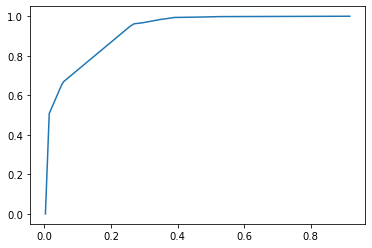

In [23]:
roc_auc_plot(yval, yval_pred_proba[:, 1])

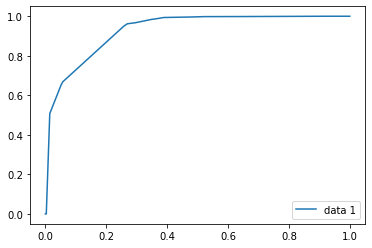

In [24]:
## SKLEARN
fpr, tpr, _ = metrics.roc_curve(yval,  yval_pred_proba[: ,1])
plt.plot(fpr,tpr,label="data 1")
plt.legend(loc=4)
plt.show()